## IMPORTS

In [1]:
import tensorflow as tf
import os
from glob import glob
!pip install -q tensorflow-io
import tensorflow_io as tfio


from matplotlib import pyplot as plt

from IPython import display
import imageio

import numpy as np
import math

## HYPERPARAMETERS

In [55]:
BUFFER_SIZE = 400
BATCH_SIZE = 2
IMG_WIDTH = 256
IMG_HEIGHT = 256

# project_name
project_name = "7Bleed_AE_Huber_BCE_Sigmoid_NormNarrow_ShuffleTr_SaveBest/"
if not os.path.exists(project_name):
    os.makedirs(project_name)
# tb_log_name 
log_dir=project_name + "AE_logs/"

# image_save name
save_figure_path =project_name + "AE_saves"

# training_checkpoint name
checkpoint_dir = project_name + "training_checkpoints"

# model architecture name
encoder_path = project_name + "Encoder.png"
decoder_path = project_name +"Decoder.png"
autoencoder_path = project_name + "Autoencoder.png"

base_model_path = project_name + "base_model.png"
classifier_path = project_name + "classifier.png"

# gif save name
anim_file = project_name + 'AE_saves.gif'

# dicom root 
dicom_root = 'E:/dataset/Leisang/myTry/BleedingDataDCM'
# for lab ubuntu:
# dicom_root = '/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM'
# # for home ubuntu:
# dicom_root = '/media/ytx/DL/dataset/Leisang/myTry/BleedingDataDCM'
train_path  = os.path.join(dicom_root, "train")
val_path =  os.path.join(dicom_root, "val")
print("dicom_root",dicom_root)
print("train_path",train_path)
print("val_path",val_path)

train_roots = sorted(glob(train_path + "/*"))
val_roots =  sorted(glob(val_path + "/*"))
print("train_roots", train_roots)
print("val_roots", val_roots)

print("# of train roots:", len(train_roots))
print("# of val roots:", len(val_roots))

train_dicom_paths = []
val_dicom_paths = []
for each_train in train_roots:
    temp_dicoms =  sorted(glob(each_train +'/*.DCM'))
    print("one roort len of dicoms:", len(temp_dicoms))
    train_dicom_paths = train_dicom_paths+ temp_dicoms
#     train_dicom_paths.append(sorted(glob(each + '/*.DCM')))

for each_val in val_roots:
    temp_dicoms =  sorted(glob(each_val +'/*.DCM'))
    print("one roort len of dicoms:", len(temp_dicoms))
    val_dicom_paths = val_dicom_paths+ temp_dicoms
#     train_dicom_paths.append(sorted(glob(each + '/*.DCM')))
print("# of train dicoms:", len(train_dicom_paths))
print()
print("train_dicom_paths[0]", train_dicom_paths[0])
print("val_dicom_paths[0]", val_dicom_paths[0])
print()
print("# of val dicoms:", len(val_dicom_paths))    

total_num_batches_per_epoch = math.ceil(len(train_dicom_paths) / BATCH_SIZE)

total_num_batches_per_val = math.ceil(len(val_dicom_paths) / BATCH_SIZE)
print("batch size:", BATCH_SIZE)
print("total_num_batches per epoch:", total_num_batches_per_epoch)
print("input shape:", [IMG_HEIGHT, IMG_WIDTH])


dicom_root E:/dataset/Leisang/myTry/BleedingDataDCM
train_path E:/dataset/Leisang/myTry/BleedingDataDCM\train
val_path E:/dataset/Leisang/myTry/BleedingDataDCM\val
train_roots ['E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-006_000', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-008_000', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-012_000', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-015_001', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-017_001', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-019_001', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-020_002', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-021_001', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-022_001', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-023_001', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-024_001', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-027_001', 'E:/dataset/Leisang/myTry/BleedingDataDCM\\train\\ZA-029_001', 'E:/

## FUNCTIONS FOR LOADING INPUTS

In [3]:
@tf.function()
def load(image_file):
    image_bytes = tf.io.read_file(image_file)
    image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)  
    # tf.uint16: 16-bit unsigned integer  [0, 65535]
    print(image_bytes)
    print("load image:", image.shape)
#     w = tf.shape(image)[1]

#     input_image = tf.cast(image, tf.int16)

    input_image = tf.cast(image, tf.float32)
    target_image = input_image


    return input_image, target_image, image_file

Tensor("ReadFile:0", shape=(), dtype=string)
load image: (None, None, None, None)
tf.Tensor(b'E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\train\\ZA-006_000\\00001083.DCM', shape=(), dtype=string)


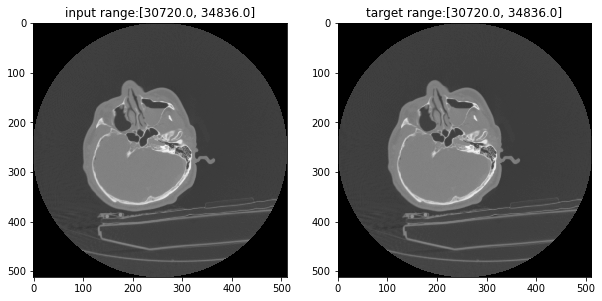

In [4]:
# # check the load fucntion
# single_dicom_path =  train_dicom_paths[1]
# print("single_dicom_path:", single_dicom_path)
# # input, target = load(single_dicom_path)
input, target, image_path = load('E:\\dataset\\Leisang\\myTry\\BleedingDataDCM\\train\\ZA-006_000\\00001083.DCM')
# # for home ubuntu system
# input, target, image_path = load('/media/ytx/DL/dataset/Leisang/myTry/BleedingDataDCM/train/ZA-006_000/00000001.DCM')

# # for lab ubuntu system
# input, target, image_path= load('/media/ytx/Japan_Deep_Data/dataset/LeiSang/myTry/BleedingDataDCM/train/ZA-006_000/00000001.DCM')
fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(np.squeeze(input.numpy()), cmap='gray')
axes[0].set_title('input range:[{}, {}]'.format((input.numpy().min()), np.max(input.numpy())))
axes[1].imshow(np.squeeze(target.numpy()), cmap='gray')
axes[1].set_title('target range:[{}, {}]'.format(np.min(target), np.max(target)))
print(image_path)

## PREPROCESSING


In [5]:
def resize(input, target):
    resized_input = tf.image.resize(input, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_target = tf.image.resize(target, [IMG_HEIGHT, IMG_WIDTH],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_input =  tf.reshape(resized_input, [IMG_HEIGHT, IMG_WIDTH, 1])
    resized_target =  tf.reshape(resized_target, [IMG_HEIGHT, IMG_WIDTH, 1])
    return  resized_input, resized_target

# @tf.function()
def truncate(x, min, max):
#     print(x.shape)
    cliped =  tf.clip_by_value(x, min, max)
    return cliped
 
def norm(x, min, max):
    # normalize_value = (value − min_value) / (max_value − min_value)
    tensor = tf.math.divide(tf.subtract(x, min),
                    tf.subtract(max, min))
    return tensor

def linear_normalization(input, target, min=30720.0, max=34816.0):
    truncated_input = truncate(input, min, max)
    truncated_target = truncate(target, min, max)
    norm_input = norm(truncated_input, min, max )
    norm_target = norm(truncated_target, min, max)
    
    return  norm_input, norm_target

range of input: [30720.0, 34836.0]
range of target: [30720.0, 34836.0]
range of resized_input: [30720.0, 34836.0]
range of resized_target: [30720.0, 34836.0]
range of cliped_input: [30720.0, 34816.0]
range of cliped_target: [30720.0, 34816.0]
resized input shape: (256, 256, 1)
range of cliped_norm_input: [0.0, 1.0]
range of cliped_norm_target: [0.0, 1.0]


Text(0.5, 1.0, 'cliped_norm_target')

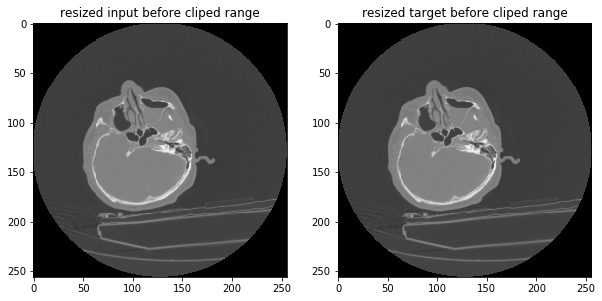

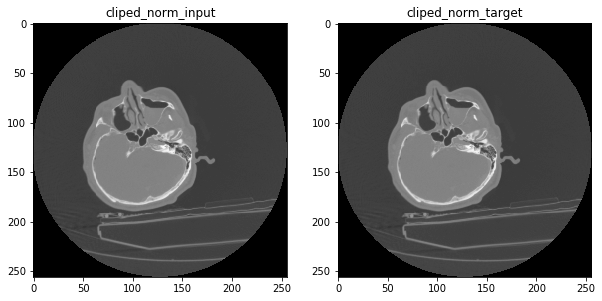

In [6]:
# check preprocessing
print("range of input: [{}, {}]".format(np.min(input), np.max(input)))
print("range of target: [{}, {}]".format(np.min(target), np.max(target)))
fig2, axes2 = plt.subplots(1,2, figsize=(10,10))
resized_input, resized_target = resize(input, target)
print("range of resized_input: [{}, {}]".format(np.min(resized_input), np.max(resized_input)))
print("range of resized_target: [{}, {}]".format(np.min(resized_target), np.max(resized_target)))

# # clipped
cliped_input = truncate(input, min=30720.0, max=34816.0)
cliped_target = truncate(target, min=30720.0, max=34816.0)
print("range of cliped_input: [{}, {}]".format(np.min(cliped_input), np.max(cliped_input)))
print("range of cliped_target: [{}, {}]".format(np.min(cliped_target), np.max(cliped_target)))


cliped_norm_input, cliped_norm_target =  linear_normalization(resized_input, resized_target)
axes2[0].imshow(np.squeeze(resized_input.numpy()), cmap='gray')
axes2[0].set_title("resized input before cliped range")
axes2[1].imshow(np.squeeze(resized_target.numpy()), cmap='gray')
axes2[1].set_title("resized target before cliped range")
print("resized input shape:", resized_input.shape)
print("range of cliped_norm_input: [{}, {}]".format(np.min(cliped_norm_input), np.max(cliped_norm_input)))
print("range of cliped_norm_target: [{}, {}]".format(np.min(cliped_norm_target), np.max(cliped_norm_target)))
# print(truncated_input.shape)
fig3, axes3 = plt.subplots(1,2, figsize=(10,10))
axes3[0].imshow(np.squeeze(cliped_norm_input.numpy()), cmap='gray')
axes3[0].set_title("cliped_norm_input")
axes3[1].imshow(np.squeeze(cliped_norm_target.numpy()), cmap='gray')
axes3[1].set_title("cliped_norm_target")

## DEFINE LOAD FUNCTION IN INPUT PIPELINE

In [7]:
def load_image_train(image_file):
    input, target, image_path= load(image_file)
    input, target = resize(input, target)
    input, target = linear_normalization(input, target)

    return input, target, image_path

def load_image_val(image_file):
    input, target, image_path = load(image_file)
    input, target = resize(input, target)
    input, target = linear_normalization(input, target)

    return input, target, image_path

## INPUT PIPELINE

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_dicom_paths)  # this can diretly get a list of kind of files
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(val_dicom_paths)
test_dataset = test_dataset.map(load_image_val)
test_dataset = test_dataset.shuffle(BUFFER_SIZE)  # for the random check if not comment it
test_dataset = test_dataset.batch(BATCH_SIZE)

Tensor("ReadFile:0", shape=(), dtype=string)
load image: (None, None, None, None)


(2, 256, 256, 1)
batch_path[0]: tf.Tensor(b'E:/dataset/Leisang/myTry/BleedingDataDCM\\val\\ZA-049_001\\00000214.DCM', shape=(), dtype=string)


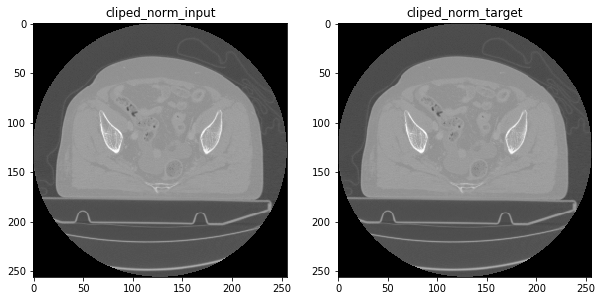

In [9]:
#  check the dataset
for one_batch_input, one_batch_target, batch_paths  in test_dataset.take(1):
    print(one_batch_input.shape)
    print("batch_path[0]:", batch_paths[0])
    fig4, axes4 = plt.subplots(1,2, figsize=(10,10))
    axes4[0].imshow(np.squeeze(one_batch_input[0].numpy()), cmap='gray')
    axes4[0].set_title("cliped_norm_input")
    axes4[1].imshow(np.squeeze(one_batch_target[0].numpy()), cmap='gray')
    axes4[1].set_title("cliped_norm_target")
    plt.show()

## DESIGN MODEL

In [10]:
OUTPUT_CHANNELS = 1
latent_dim =50

In [11]:
# model input conponents
en_inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_HEIGHT,1])
de_inputs = tf.keras.layers.Input(shape=[latent_dim])
# full model design and construct encoder, decoder , AE object
# entire model

# Define encoder part ---->
x = en_inputs
x = tf.keras.layers.Conv2D(
                filters=16, kernel_size=3, strides=(1, 1), activation='relu', padding="same")(x)
x = tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu', padding="same")(x)
x = tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu', padding="SAME")(x)
x = tf.keras.layers.Conv2D(
                filters=128, kernel_size=3, strides=(2, 2), activation='relu',padding="SAME")(x)
x = tf.keras.layers.Flatten()(x)
# No activation
latent_v = tf.keras.layers.Dense(latent_dim)(x)
encoder = tf.keras.Model(inputs=en_inputs, outputs=latent_v, name='encoder')


# Define decoder part ---->
x = tf.keras.layers.Dense(units=131072, activation=tf.nn.relu)(de_inputs)
x = tf.keras.layers.Reshape(target_shape=(32, 32, 128))(x)
x = tf.keras.layers.Conv2DTranspose(
      filters=64,
      kernel_size=3,
      strides=(2, 2),
      padding="SAME",
      activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(
      filters=32,
      kernel_size=3,
      strides=(2, 2),
      padding="SAME",
      activation='relu')(x)
x = tf.keras.layers.Conv2DTranspose(
      filters=16,
      kernel_size=3,
      strides=(2, 2),
      padding="SAME",
      activation='relu')(x)

decoded = tf.keras.layers.Conv2DTranspose(
      filters=1, kernel_size=3, strides=(1, 1), padding="SAME", use_bias=True)(x)
# output with sigmoid
decoded =  tf.sigmoid(decoded)
decoder = tf.keras.Model(inputs=de_inputs, outputs=decoded, name='decoder')


# Define AE model---->
outputs = decoder(latent_v)
autoencoder =  tf.keras.Model(inputs=en_inputs, outputs=outputs, name='AE')

# a sperately decoder is struggle leave for the moment

# # # create a placeholder for an encoded (32-dimensional) input
# encoded_input = tf.keras.layers.Input(shape=(latent_dim))
# # # retrieve the last layer of the autoencoder model
# decoder_layer = autoencoder.layers[-1]
# # # create the decoder model
# decoder = tf.keras.Model(encoded_input, decoder_layer)
             

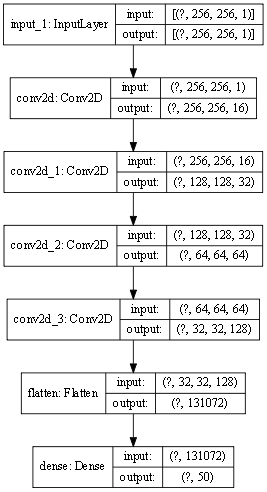

In [12]:
tf.keras.utils.plot_model(encoder, to_file=encoder_path, show_shapes=True, dpi=64)

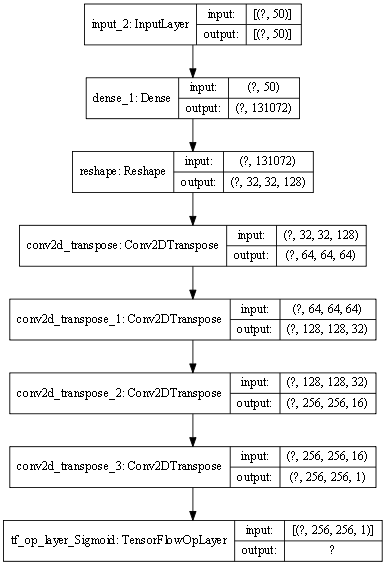

In [13]:
tf.keras.utils.plot_model(decoder, to_file=decoder_path, show_shapes=True, dpi=64)

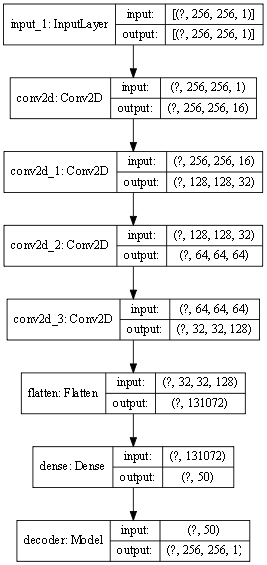

In [14]:
tf.keras.utils.plot_model(autoencoder, to_file=autoencoder_path, show_shapes=True, dpi=64)

## OPTIMIZER AND OBJECTIVE LOSSES


In [15]:
# define opitmizer 
optimizer =  tf.keras.optimizers.Adam(1e-4)
BCE =  tf.keras.losses.BinaryCrossentropy() 
Huber =  tf.keras.losses.Huber(delta=0.1)
@tf.function()
# define losses
def compute_loss(decoded_x, x):
    
    # cross_entropy,  use reduce mean not sum, otherwise loss will be very big
    BCE_loss = BCE(y_true=x, y_pred=decoded_x) 
    
    
    # L1 loss 
#     L1_loss = tf.reduce_mean(tf.abs(x - decoded_x))
    
    # Huber_loss
    Huber_loss = Huber(y_true=x, y_pred=decoded_x)
    total_loss = Huber_loss + BCE_loss
    return total_loss, BCE_loss, Huber_loss
    
# appliy graidients  this is acutaully trianing step
# @tf.function()
# def compute_apply_gradients(model, x, optimizer, epoch):
#     decoded_x =  model(x)
#     with tf.GradientTape() as tape:
#         total_loss, CE_loss, L1_loss = compute_loss(decoded_x, x)
#     gradients = tape.gradient(total_loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
#     with summary_writer.as_default():
#         # write scalars to the tensorboard after each train step
#         tf.summary.scalar('total_loss', total_loss, step=epoch)
#         tf.summary.scalar('CE_loss', CE_loss, step=epoch)
#         tf.summary.scalar('L1_loss', L1_loss, step=epoch) 
@tf.function()
def train_step(model, input, target, epoch):
    print("in trianing step")
    with tf.GradientTape() as tape:  # very interesting
        decoded_img = model(input, training=True)
        total_loss, BCE_loss, Huber_loss = compute_loss(decoded_img, target)
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, BCE_loss, Huber_loss

@tf.function()
def test_step(model, input, target, epoch):
    with tf.GradientTape() as tape:  # very interesting
        decoded_img = model(input, training=True)
        total_loss, BCE_loss, Huber_loss = compute_loss(decoded_img, target)
    return total_loss, BCE_loss, Huber_loss
#     train_avg_loss(train_loss)
#     train_avg_metric(metric)     

inp.shape: (256, 256, 1)
inp[tf.newaxis,...]: (1, 256, 256, 1)
(1, 256, 256, 1)


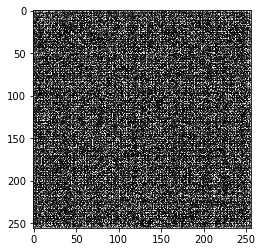

In [16]:
# check the AE OUTPUT
print("inp.shape:", cliped_norm_input.shape)
print("inp[tf.newaxis,...]:", cliped_norm_input[tf.newaxis,...].shape)
AE_output = autoencoder(resized_input[tf.newaxis,...], training=False)  # inp is the image sample from cell code 6 ; 
print(AE_output.shape)
plt.imshow(np.squeeze(AE_output[0,...]), cmap="gray")

## Training PREPARING

In [41]:

# define the epoch image check
def generate_images(model, test_input, tar, path, total_loss, batch_idx, epoch, save=True):
    prediction = model(test_input, training=True)

   

    display_list = [np.squeeze(test_input[0]), np.squeeze(tar[0]), np.squeeze(prediction[0])]
    title = ['Input range:[{},{}]'.format(test_input[0].numpy().min(), test_input[0].numpy().max()), 
           'GT range:[{},{}]'.format(tar[0].numpy().min(), tar[0].numpy().max()), 'Pred. [B:{}/E:{}]: loss->'.format(batch_idx,epoch)+ str(total_loss)]
    
    fig5 = plt.figure(figsize=(15,5))
    fig5.suptitle(str(path[0].numpy(), 'utf-8')) # decode convert byte b'' to normal ''
  
    for i in range(3):
        ax = fig5.add_subplot(1,3, i+1,title=title[i])
        # getting the pixel values between [0, 1] to plot it.
        ax.imshow(display_list[i], cmap="gray") # prediction in range[-1, 1]*0.5 = [-0.5, 0.5],+ 0.5=[0, 1]
        ax.axis('off')
     
    if save==True:
        fig5.savefig(save_figure_path + "/image_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
    
    plt.figure(figsize=(8,8))
    plt.title('Pred. [B:{}/E:{}]: loss->'.format(batch_idx,epoch)+ str(total_loss))
    plt.imshow(np.squeeze(prediction[0]), cmap="gray") # prediction in range[-1, 1]*0.5 = [-0.5, 0.5],+ 0.5=[0, 1]
    plt.axis('off')
    if save ==True:
        plt.savefig(save_figure_path + "/Predictions/pred_only_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
    plt.show()


# define the  encoder latent space check
def en_generate_images(model, test_input, tar, path, batch_idx, epoch, save=True):
    prediction = model(test_input, training=True)

   

    display_list = [np.squeeze(test_input[0]), np.squeeze(tar[0]), np.squeeze(prediction[0])]
    title = ['Input range:[{},{}]'.format(test_input[0].numpy().min(), test_input[0].numpy().max()), 
           'GT range:[{},{}]'.format(tar[0].numpy().min(), tar[0].numpy().max()), 'Pred. Latent Space {}'.format(prediction[0].shape)]
    
    fig5 = plt.figure(figsize=(15,5))
    fig5.suptitle(str(path[0].numpy(), 'utf-8')) # decode convert byte b'' to normal ''
  
    for i in range(3):
        ax = fig5.add_subplot(1,3, i+1,title=title[i])
        # getting the pixel values between [0, 1] to plot it.
        ax.imshow(display_list[i], cmap="gray") # prediction in range[-1, 1]*0.5 = [-0.5, 0.5],+ 0.5=[0, 1]
        ax.axis('off')
     
    if save==True:
        fig5.savefig(save_figure_path + "/image_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
    
    plt.figure(figsize=(8,8))
    plt.title('Pred. Latent Space {}'.format(prediction[0].shape))
#     plt.imshow(np.squeeze(prediction[0]), cmap="gray") # prediction in range[-1, 1]*0.5 = [-0.5, 0.5],+ 0.5=[0, 1]
    plt.axis('off')
    if save ==True:
        plt.savefig(save_figure_path + "/Predictions/pred_only_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
    plt.show()


def en_de_generate_images(encoder,decoder, test_input, tar, path, batch_idx, epoch, save=True):
#     prediction = model(test_input, training=True)
    latent_v = encoder(test_input, training=False)
    prediction = decoder(latent_v)

    display_list = [np.squeeze(test_input[0]), np.squeeze(tar[0]), np.squeeze(prediction[0])]
    title = ['Input range:[{},{}]'.format(test_input[0].numpy().min(), test_input[0].numpy().max()), 
           'GT range:[{},{}]'.format(tar[0].numpy().min(), tar[0].numpy().max()), 'en-to-de Pred. out {}'.format(prediction.shape)]
    
    fig5 = plt.figure(figsize=(15,5))
    fig5.suptitle(str(path[0].numpy(), 'utf-8')) # decode convert byte b'' to normal ''
  
    for i in range(3):
        ax = fig5.add_subplot(1,3, i+1,title=title[i])
        # getting the pixel values between [0, 1] to plot it.
        ax.imshow(display_list[i], cmap="gray") # prediction in range[-1, 1]*0.5 = [-0.5, 0.5],+ 0.5=[0, 1]
        ax.axis('off')
     
    if save==True:
        fig5.savefig(save_figure_path + "/image_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
    
    plt.figure(figsize=(8,8))
    plt.title('en-to-de Pred. out {}'.format(prediction.shape))
    plt.imshow(np.squeeze(prediction[0]), cmap="gray") # prediction in range[-1, 1]*0.5 = [-0.5, 0.5],+ 0.5=[0, 1]
    plt.axis('off')
    if save ==True:
        plt.savefig(save_figure_path + "/Predictions/pred_only_at_epoch_{:04d}_batch_{}.png".format(epoch,batch_idx))
    plt.show()

## TRAINING

In [42]:
import datetime

epochs = 100

## get current working directory
cwd = os.getcwd()
print("current working directory:", cwd)




full_AE_saves =  os.path.join(cwd, save_figure_path)
print(full_AE_saves)
if not os.path.exists(full_AE_saves):
    os.makedirs(full_AE_saves)
predictions_save_path =os.path.join(full_AE_saves, "Predictions")

if not os.path.exists(predictions_save_path):
    os.makedirs(predictions_save_path)

# define check points


# pre_saved_ckpt_path = os.path.join(checkpoint_dir, "ckpt")
# change to pre-saved model path: 
# 8 
pre_saved_ckpt_path = "E:\\Projects\\logs\dicoms\\fixedArranged\\fixed\\8Bleed_AE_Huber_BCE_Sigmoid_NormNarrow_ShuffleTr_RandWinTrTe_SaveBest\\training_checkpoints\\ckpt"


if not os.path.exists(pre_saved_ckpt_path):
    print("please check the pre-trained saved model path")
#  contents of states to be saved as attributes on the checkpoint object
checkpoint_ob = tf.train.Checkpoint(step= tf.Variable(1),
                                    epoch=  tf.Variable(1),
                                    optimizer=optimizer,
                                 encoder=encoder,
                                 decoder =  decoder,
                                 autoencoder = autoencoder
                                 )
# define checkpoint manager
manager =  tf.train.CheckpointManager(checkpoint_ob, pre_saved_ckpt_path, max_to_keep=1)


datetime_rec =  datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_summary_writer = tf.summary.create_file_writer(
  log_dir + "train")
val_summary_writer = tf.summary.create_file_writer(
  log_dir + "val")

current working directory: E:\Projects\TF2\Dicom
E:\Projects\TF2\Dicom\7Bleed_AE_Huber_BCE_Sigmoid_NormNarrow_ShuffleTr_SaveBest/AE_saves


In [43]:
# start tensorboard
# !kill 5032
%load_ext tensorboard
%tensorboard --logdir {log_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 25136), started 19:59:38 ago. (Use '!kill 25136' to kill it.)

18313
6


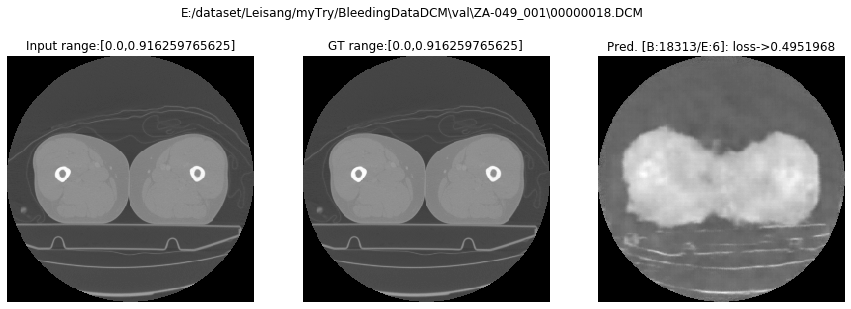

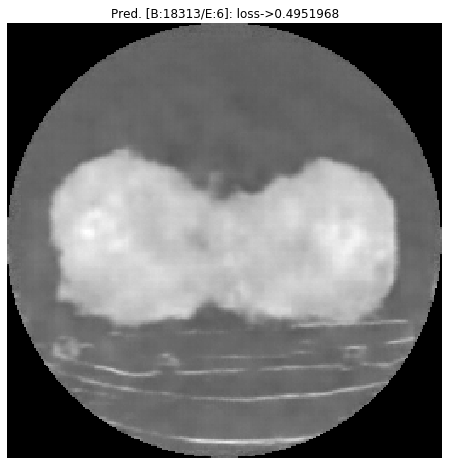

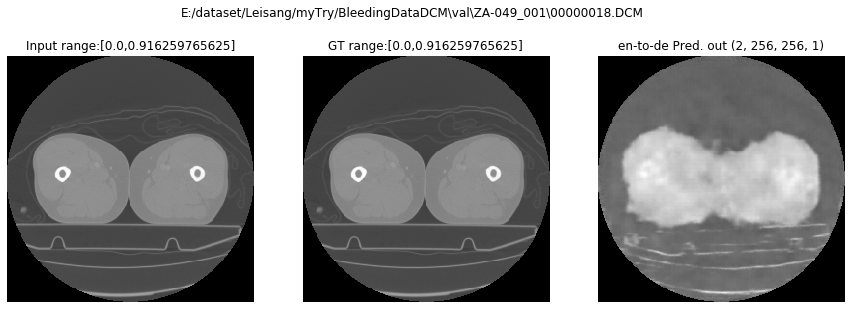

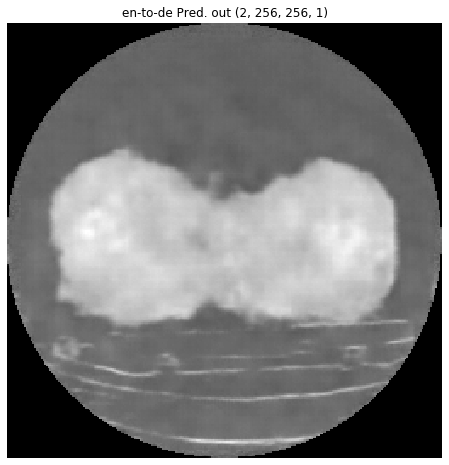

In [44]:
# load pre-trained model
checkpoint_ob.restore(manager.latest_checkpoint)

step =  checkpoint_ob.step
epoch =  checkpoint_ob.epoch
print(int(step))
print(int(epoch))

AE=  checkpoint_ob.autoencoder
en = checkpoint_ob.encoder
de =  checkpoint_ob.decoder
print(AE)

# check the loaded ae output

for TEST_input, TEST_target, TEST_path in test_dataset.take(1):  # take one data from the test set
    test_total_loss, test_BCE_loss, test_Huber_loss = test_step(AE, TEST_input, TEST_target, epoch) 
    generate_images(AE, TEST_input, TEST_target,TEST_path,test_total_loss.numpy(), int(step), int(epoch), save=False)
    
    # check the loaded encoder and decoder
    en_de_generate_images(en, de,TEST_input, TEST_target,TEST_path, int(step), int(epoch), save=False)

## use the pre-saved encoder as the base model and design the new model
base_model  = en
print(base_model.trainable)

In [57]:
base_model =  en # use encoder as the base model

# check the base base model traininable
print(base_model.trainable)

# 
trainable_or_not =  True

if trainable_or_not == True:
    base_model.trainable =  True # set encoder untranable
print("after reset basemodel trainable property:", base_model.trainable)

False
after reset basemodel trainable property: True


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 50)                6553

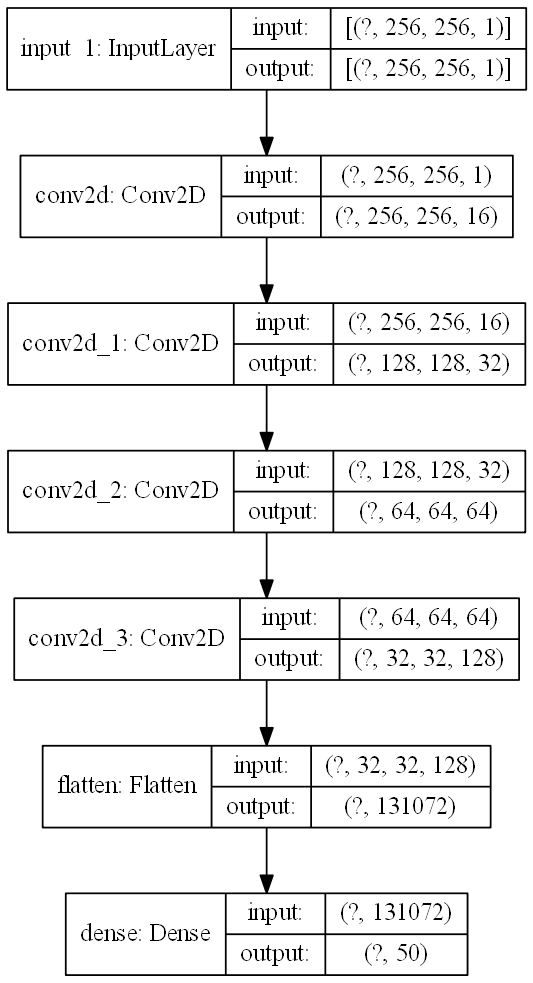

In [58]:
# check the trainable model architecture
base_model.summary()
tf.keras.utils.plot_model(base_model, to_file=base_model_path, show_shapes=True, dpi=128)

# of layers in the base_model: 7
Tensor("dense/Identity:0", shape=(None, 50), dtype=float32)
Tensor("dense/Identity:0", shape=(None, 50), dtype=float32)
Model: "classifier_head"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (

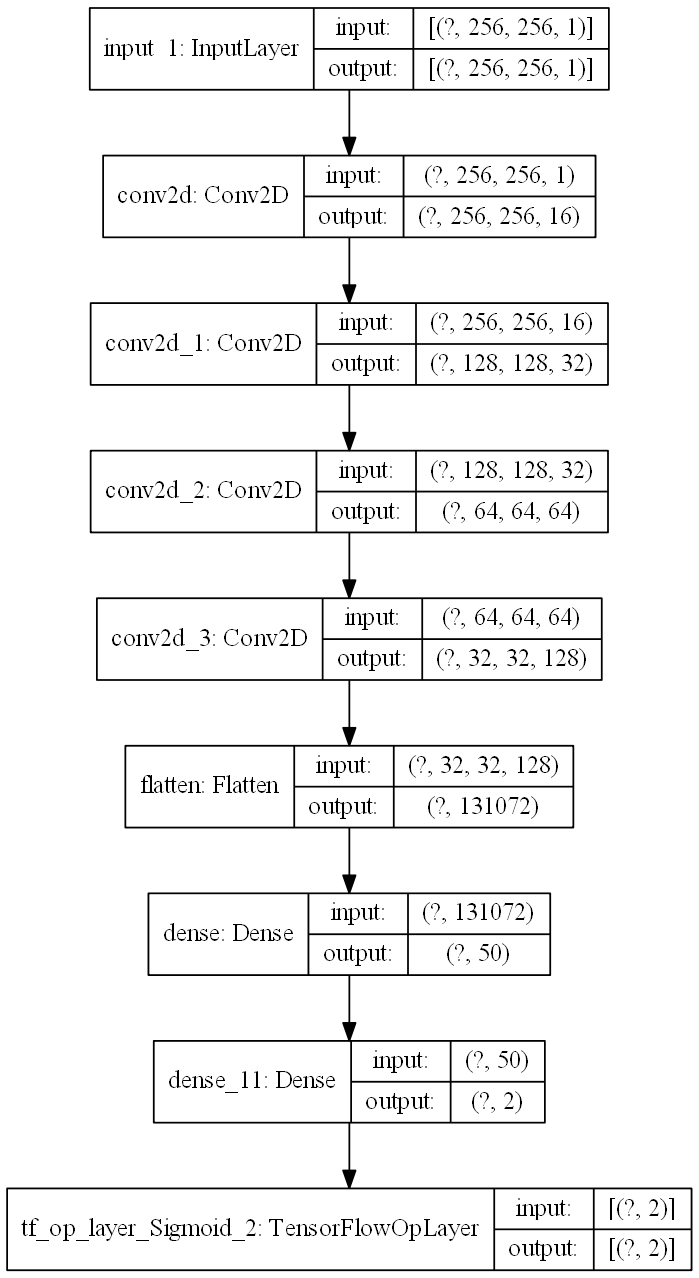

In [133]:
# add classification head for bleed exist or not
print("# of layers in the base_model:", len(base_model.layers))
class_head_nodes = tf.keras.layers.Dense(2)(base_model.layers[-1].output)
class_sigmoid_output =  tf.sigmoid(class_head_nodes)
print(base_model.output)
print(base_model.layers[-1].output)
Classifier =  tf.keras.Model(inputs=en_inputs, outputs=class_sigmoid_output, name='classifier_head')
# check the architecture
Classifier.summary()
tf.keras.utils.plot_model(Classifier, to_file=classifier_path, show_shapes=True, dpi=128)

Tensor("conv2d_3/Identity:0", shape=(None, 32, 32, 128), dtype=float32)
Tensor("sequential_250/Identity:0", shape=(None, 32, 32, 256), dtype=float32)
Tensor("concatenate_101/Identity:0", shape=(None, 32, 32, 384), dtype=float32)
one more step encoding: Tensor("sequential_113/Identity:0", shape=(None, 16, 16, 512), dtype=float32)
GA: Tensor("global_average_pooling2d_38/Identity:0", shape=(None, 512), dtype=float32)
RESHAPE_GA: Tensor("Reshape_34:0", shape=(None, 1, 1, 512), dtype=float32)
resized GA: Tensor("resize_32/ResizeBilinear:0", shape=(None, 16, 16, 512), dtype=float32)
bottom_concate: Tensor("concatenate_102/Identity:0", shape=(None, 16, 16, 1024), dtype=float32)

start to upsample--------->
up_feature1: Tensor("sequential_252/Identity:0", shape=(None, 32, 32, 512), dtype=float32)
up_concate1: Tensor("concatenate_103/Identity:0", shape=(None, 32, 32, 768), dtype=float32)
up_feature2: Tensor("sequential_253/Identity:0", shape=(None, 64, 64, 256), dtype=float32)
up_concate2: Tens

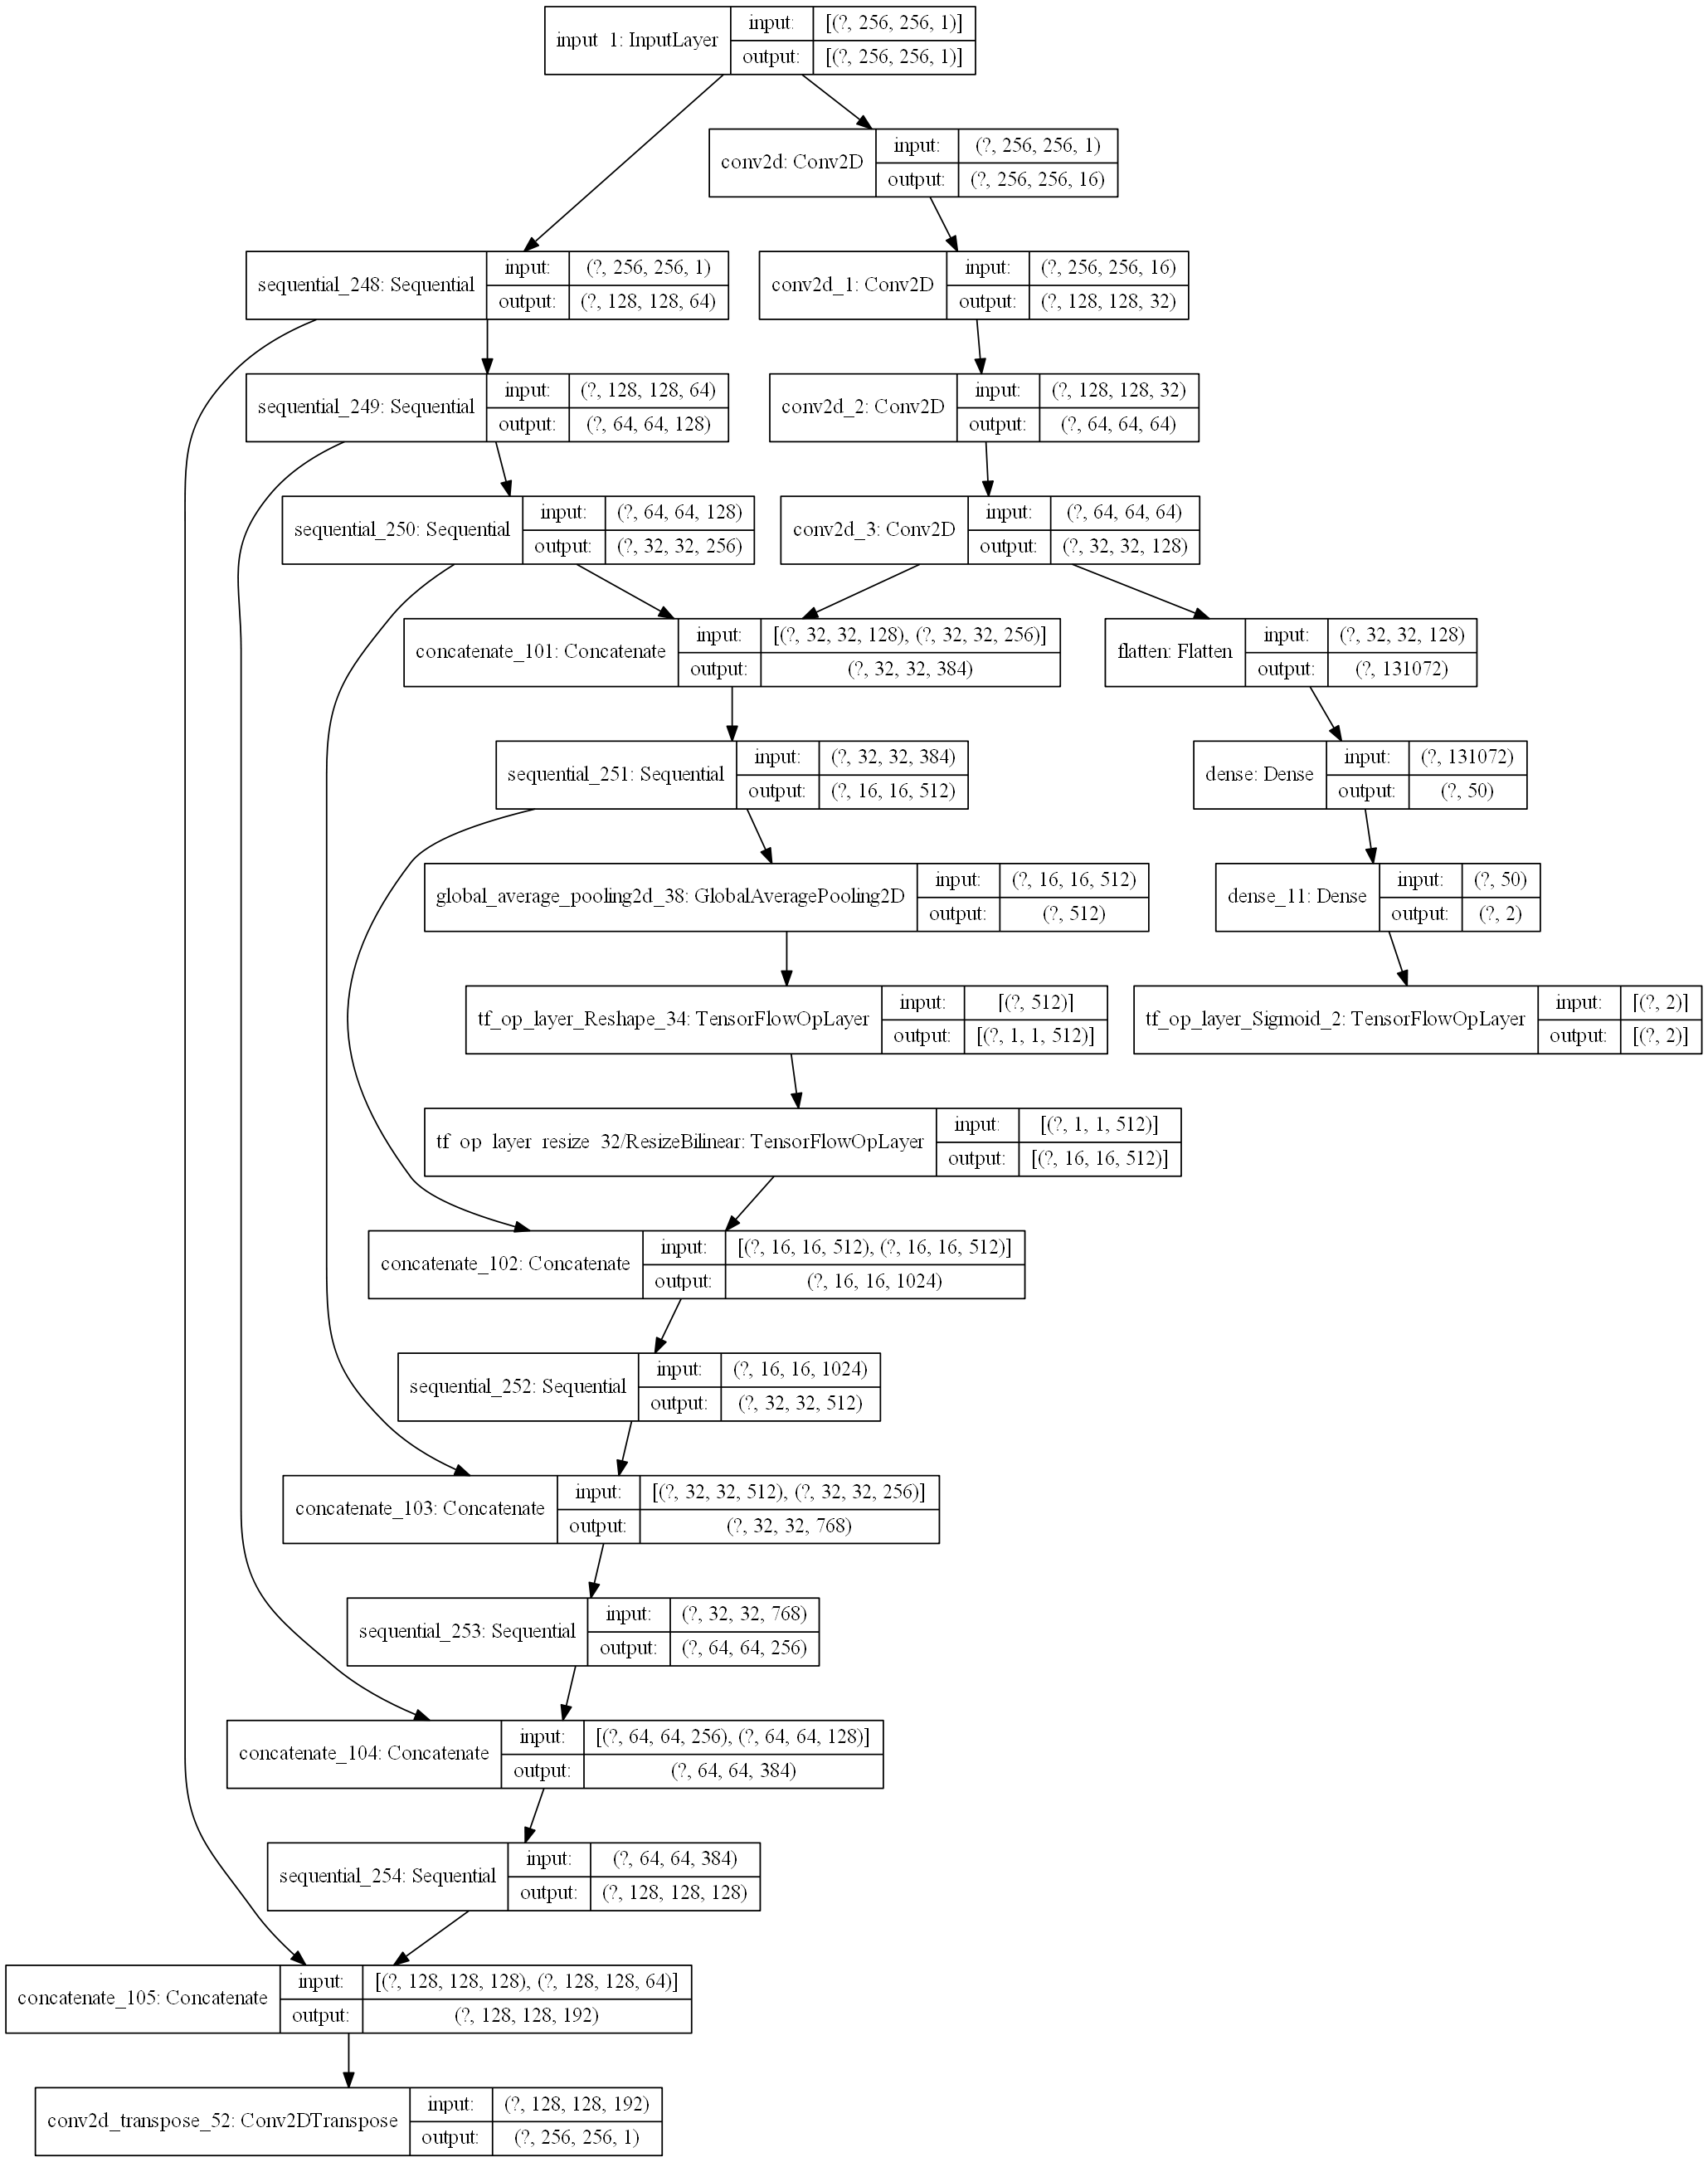

In [135]:
# set THE SETMENTATION PART
# 1st take out the feature from the base_model
base_feature =  base_model.layers[-3].output
print(base_feature)


# define down_sample block as the pix-2-pix from tensorflow official set
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result


# def skips needed to be connected
skips = []

def en_for_seg():
# new another path for the segmentation of the new model
    x = downsample(64, 4, apply_batchnorm=False)(en_inputs) # output  (None, 128, 128, 64)
    skips.append(x)
    x = downsample(128, 4)(x)  # output (None, 64, 64, 128)
    skips.append(x)
    x = downsample(256, 4)(x)  # output (None, 32, 32, 256)
    skips.append(x)
    # if want seperate train the generator, return the Model object e.g. return tf.keras.Model(inputs=inputs, outputs=x)
    return tf.keras.Model(inputs=en_inputs, outputs=x)

en_coder_for_seg_out =  en_for_seg()
print(en_coder_for_seg_out.output)
tf.keras.utils.plot_model(en_coder_for_seg_out, to_file="encodre_for_seg.png", show_shapes=True, dpi=128)





# concatenate the feature from base and feature from the new enocoder
concate_features =  tf.keras.layers.Concatenate()([base_feature, en_coder_for_seg_out.output])
print(concate_features)

# start to one more step to encoder
further_en = downsample(512, 4)(concate_features)  # output (None, 16, 16, 512)
print("one more step encoding:",future_en)

# global pooling for that one more step encoding fetures
GA  = tf.keras.layers.GlobalAveragePooling2D()(further_en)  # squeeze
print("GA:", GA)
# RESHAPE GA  TO THE IMAGE FORMMAT
RESHAPE_GA =  tf.reshape(GA, [-1,1,1, GA.shape[-1]])
print("RESHAPE_GA:", RESHAPE_GA)
#resize to the feature maps size
resize_GA =  tf.image.resize(RESHAPE_GA, (x.shape[1], x.shape[2]))
print("resized GA:", resize_GA)
# concate future_en and reisze_GA
bottom_concate =  tf.keras.layers.Concatenate()([resize_GA, further_en])
print("bottom_concate:", bottom_concate)

print()
print("start to upsample--------->")
# start to upsample and decoder from resize_GA and further_en
up_feature1 =  upsample(512, 4) (bottom_concate) #  upsample/relarge ti [None, 32, 32, 1024] without dropout default false for drop
print("up_feature1:", up_feature1)
up_concate1 =  tf.keras.layers.Concatenate()([up_feature1, skips[-1]])
print("up_concate1:", up_concate1)
up_feature2 =  upsample(256, 4) (up_concate1) #  upsample/relarge ti [None, 64, 64, 256] without dropout default false for drop
print("up_feature2:", up_feature2)
up_concate2 =  tf.keras.layers.Concatenate()([up_feature2, skips[-2]])
print("up_concate2:", up_concate2)
up_feature3 =  upsample(128, 4) (up_concate2) #  upsample/relarge ti [None, 128, 128, 128] without dropout default false for drop
print("up_feature3:", up_feature2)
up_concate3 =  tf.keras.layers.Concatenate()([up_feature3, skips[-3]])
print("up_concate3:", up_concate3)

# last layer output
initializer = tf.random_normal_initializer(0., 0.02)
last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2, # stride 2
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='sigmoid') # (bs, 256, 256, 3)
seg_out  =  last(up_concate3)

Final_seg_model = tf.keras.Model(inputs=en_inputs, outputs=[seg_out, class_sigmoid_output])
tf.keras.utils.plot_model(Final_seg_model, to_file="new_model.png", show_shapes=True, dpi=128)

In [79]:
import time

# check the whether there is a checkpoint in the checkpoint folder, if it is restore from it
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
    checkpoint_ob.restore(manager.latest_checkpoint)
else:
    print("Initializing from scratch.")

# reset checkcpoint.step for each epoch
step =  checkpoint_ob.step
ckpt_epoch =  checkpoint_ob.epoch  

# test average_loss = for saving the test results
test_avg_tmp_loss = 100

for epoch in range(int(ckpt_epoch), epochs+1):
    train_total_loss_mean = tf.keras.metrics.Mean()
    train_BCE_loss_mean = tf.keras.metrics.Mean()
    train_Huber_loss_mean = tf.keras.metrics.Mean()
   
    
    # initial saving of checkpoints
#     if epoch == 1:
#         save_path =  manager.save()
#         print("Initial saving checkpoints at epoch {} batch {} at path {}".format(int(ckpt_epoch),  int(step) ,save_path))
       
        
    
    start_time =  time.time()
    for train_x, target, _ in train_dataset:
#         print(train_x.shape)
#         print(target.shape)
#         print(autoencoder)
        # one training step
        total_loss, BCE_loss, Huber_loss = train_step(autoencoder, train_x, target, epoch)
        end_time =  time.time()
        
        # calculate mean value for trainning losses
        train_total_loss_mean(total_loss)
        train_BCE_loss_mean(BCE_loss)
        train_Huber_loss_mean(Huber_loss)
        
        #
        if int(step) == 1:
            for example_input, example_target, example_path in test_dataset.take(1):
                generate_images(autoencoder, example_input, example_target, example_path,total_loss.numpy(), int(step), epoch)
        
        # every 100 batch step show the generate test image to check.
        if int(step) % 100 == 0:
            display.clear_output(wait=True)   
            for example_input, example_target, example_path in test_dataset.take(1):
                generate_images(autoencoder, example_input, example_target,example_path,total_loss.numpy(), int(step), epoch)
                # every 400 steps save the genrate images
          
            print('Epoch{}: {}/{}: total_loss: {}; BCE__loss: {}; Huber_loss: {} '
          'time elapse {}'.format(int(ckpt_epoch), int(step), total_num_batches_per_epoch, total_loss, BCE_loss, Huber_loss, end_time-start_time))
                       
             
        
          
        
        step.assign_add(1)
        
    # print validation step
    if ckpt_epoch % 1 == 0:
        test_total_loss_mean = tf.keras.metrics.Mean()
        test_BCE_loss_mean = tf.keras.metrics.Mean()
        test_Huber_loss_mean = tf.keras.metrics.Mean()
        for (test_x, test_target, example_path) in test_dataset:
            test_total_loss, test_BCE_loss, test_Huber_loss = test_step(autoencoder, test_x, test_target, epoch)
            test_total_loss_mean(test_total_loss)
            test_BCE_loss_mean(test_BCE_loss)
            test_Huber_loss_mean(test_Huber_loss)
                                                             
      
        
        print('Epoch: {}, Test total_loss set loss: {},  time elapse for current epoch {}'.format(int(ckpt_epoch),
                                                    test_total_loss_mean.result(),
                                                    end_time - start_time))
        
        with train_summary_writer.as_default():
            print("writing train logs to tensorboard...")                                                       
            # write scalars to the tensorboard after each train step
            tf.summary.scalar('total_loss', train_total_loss_mean.result(), step=epoch)
            tf.summary.scalar('BCE_loss', train_BCE_loss_mean.result(), step=epoch)
            tf.summary.scalar('Huber_loss', train_Huber_loss_mean.result(), step=epoch)
            
        with val_summary_writer.as_default():
            print("writing val logs to tensorboard...")                                                        
            # write scalars to the tensorboard after each train step
            tf.summary.scalar('total_loss', test_total_loss_mean.result(), step=epoch)
            tf.summary.scalar('BCE_loss', test_BCE_loss_mean.result(), step=epoch)
            tf.summary.scalar('Huber_loss', test_Huber_loss_mean.result(), step=epoch)
            
        if test_total_loss_mean.result() < test_avg_tmp_loss:
            save_path =  manager.save() # save the checkpoint and return the save path
            print("Saved checkpoint for epoch {}-  step {}: {}".format(int(ckpt_epoch), int(step), save_path))
            test_avg_tmp_loss =  test_total_loss_mean.result()
            
        
    ckpt_epoch.assign_add(1)     
    step.assign(1)

#     # saving (checkpoint) the model every 5 epochs
#     if epoch % 5 == 0:
#         print("saving checkpoints at epoch {}".format(epoch))
#         checkpoint.save(file_prefix = checkpoint_prefix)

print("training finished")   


### Generate a GIF of all the saved images.

In [ ]:
print("found save figures #: ",len(glob(full_AE_saves+ '/*.png')))

In [ ]:


with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob(full_AE_saves+ '/*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
  display.Image(filename=anim_file)